# Metadata

```
Course:   DS 5001
Module:   04 Lab
Topic:    Predict POS with an HMM
Author:   R.C. Alvarado
```

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
SENT = OHCO[:4]

In [3]:
import pandas as pd
import numpy as np
import nltk
import re

# Get Annotated `TOKEN` Table

We use the `CORPUS` table from our previous exercise.

In [4]:
TOKEN = pd.read_csv(f"{data_home}/output/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [5]:
TOKEN[['pos','term_str']].head(20)

pos       term_str
book_id chap_id para_num sent_num token_num                     
105     1       0        0        0           NNP            sir
                                  1           NNP         walter
                                  2           NNP         elliot
                                  3            IN             of
                                  4           NNP       kellynch
                                  5           NNP           hall
                                  6            IN             in
                                  7           NNP  somersetshire
                                  8           VBD            was
                                  9            DT              a
                                  10           NN            man
                                  11           NN            who
                                  12           IN            for
                                  13         PRP$            his
                                  14           JJ            own
                                  15           NN      amusement
                                  16           RB          never
                                  17          VBD           took
                                  18           RP             up
                                  19           DT            any

# Create Table of POS Tags 

We create a table rrom the Penn Treebank Project list of part-of-speech tags.

## Grab UPenn Codes

We get a text version of the UPenn Codes, or tag set, by calling `nltk.help.upenn_tagset()`. The extra information can be used later in visualizations, etc.

In [6]:
POS = pd.read_csv(f'{data_home}/misc/upenn_tagset.txt', sep='\t', names=['pos_code','def'])
POS = POS[POS.pos_code.str.match(r'^\w')].set_index('pos_code') # Keep only letter codes

In [7]:
# POS

## Add value counts

In [55]:
POS['n'] = TOKEN.pos.value_counts().to_frame().sort_index()
POS['n'] = POS['n'].fillna(0).astype('int')

In [56]:
# POS

In [57]:
POS.sort_values('n', ascending=False)

,def,n,pos_group
pos_code,,,
NN,"noun, common, singular or mass",368074,NN
IN,"preposition or conjunction, subordinating",253850,IN
DT,determiner,196237,DT
JJ,"adjective or numeral, ordinal",148862,JJ
RB,adverb,109713,RB
VBD,"verb, past tense",100279,VB
NNP,"noun, proper, singular",94848,NN
VB,"verb, base form",87697,VB
CC,"conjunction, coordinating",80782,CC


## Create `POS_GROUP` table

We want a simplified list of grammatical categories. We use the first two letters of each code name as our group.

In [58]:
# Add pos_group feature to POS and TOKEN
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)
TOKEN['pos_group'] = TOKEN.pos.str[:2]

In [59]:
# Generate new table from it
POS_GROUP = POS.groupby('pos_group').n.sum().to_frame('n')
POS_GROUP = POS_GROUP[POS_GROUP.n > 0]
POS_GROUP['def'] = POS.groupby('pos_group').apply(lambda x: '; '.join(x['def']))
POS_GROUP['p'] = POS_GROUP.n / POS_GROUP.n.sum()
POS_GROUP['i'] = np.log2(1/POS_GROUP.p)
POS_GROUP['h'] = POS_GROUP.p * POS_GROUP.i

In [63]:
POS_GROUP.sort_values('i').style.background_gradient(cmap='YlGnBu')

,n,def,p,i,h
pos_group,,,,,
NN,519388,"noun, common, singular or mass; noun, proper, singular; noun, proper, plural; noun, common, plural",0.290545,1.783165,0.518090
VB,344697,"verb, base form; verb, past tense; verb, present participle or gerund; verb, past participle; verb, present tense, not 3rd person singular; verb, present tense, 3rd person singular",0.192823,2.374649,0.457888
IN,253850,"preposition or conjunction, subordinating",0.142003,2.816002,0.399882
DT,196237,determiner,0.109775,3.187381,0.349894
JJ,158512,"adjective or numeral, ordinal; adjective, comparative; adjective, superlative",0.088671,3.495386,0.309941
RB,115087,"adverb; adverb, comparative; adverb, superlative",0.064380,3.957253,0.254766
CC,80782,"conjunction, coordinating",0.045189,4.467872,0.201900
TO,53731,"""to"" as preposition or infinitive marker",0.030057,5.056151,0.151973
MD,31028,modal auxiliary,0.017357,5.848335,0.101510


## Remove punctation from `TOKEN`

In [61]:
TOKEN = TOKEN.join(POS, on="pos_group", rsuffix='_y').dropna()

In [62]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       0        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     0        50       6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  \
book_id chap_id para_num sent_num token_num                              
105     1       0        0        0                   Sir          sir   
                                  1                Walter       walter   
                                  2               Elliot,       elliot   
                                  3                    of           of   
                                  4              Kellynch     kellynch   
...                                                   ...          ...   
34970   114     0        50       6                   The          the   
                                  7          Ambiguities,  ambiguities   
                                  8                    by           by   
                                  9                Herman       herman   
                                  10             Melville     melville   

                                            pos_group  \
book_id chap_id para_num sent_num token_num             
105     1       0        0        0                NN   
                                  1                NN   
                                  2                NN   
                                  3                IN   
                                  4                NN   
...                                               ...   
34970   114     0        50       6                DT   
                                  7                NN   
                                  8                IN   
                                  9                NN   
                                  10               NN   

                                                                                    def  \
book_id chap_id para_num sent_num token_num                                               
105     1       0        0        0                      noun, common, singular or mass   
                                  1                      noun, common, singular or mass   
                                  2                      noun, common, singular or mass   
                                  3           preposition or conjunction, subordinating   
                                  4                      noun, common, singular or mass   
...                                                                                 ...   
34970   114     0        50       6                                          determiner   
                                  7                      noun, common, singular or mass   
                                  8           preposition or conjunction, subordinating   
                                  9                      noun, common, singular or mass   
                                  10                     noun, common, singular or mass   

                                                    n pos_group_y  \
book_id chap_id para_num sent_num token_num                         
105     1       0        0    

# Implement HMM Model 

<img src="images/hmm.png" width="750">

## Create Table of $t_n \rightarrow t_{n+1}$ Transisions ($A$)

**Add sentence boundaries to sequence**

Note that we are breaking our data by adding `<s>` as a key, although 
it is not part of the UPenn tagset. We might consider creating a code 
for sentence beginnings or endings, such as the stop tag in Eistenstein 2019.

In [17]:
T1 = TOKEN.pos_group.to_frame().reset_index().copy()
T2 = T1.copy()
T1.token_num += 1
A = T1.merge(T2, on=OHCO, how='outer').fillna('<s>')\
    [['pos_group_x', 'pos_group_y']].value_counts().to_frame('n')
A['cp'] = A.n / A.groupby('pos_group_x').n.sum()  # P(y|x)
A['rcp'] = A.n / A.groupby('pos_group_y').n.sum() # P(x|y)

In [18]:
A.sort_values('cp', ascending=False).head(10).style.background_gradient(cmap='YlGnBu')

,,n,cp,rcp
pos_group_x,pos_group_y,,,
EX,VB,2775,0.756337,0.008051
UH,NN,50,0.694444,0.000096
TO,VB,36015,0.670283,0.104483
DT,NN,128490,0.654769,0.247387
MD,VB,20269,0.653249,0.058802
JJ,NN,97080,0.612446,0.186912
CD,NN,6153,0.511386,0.011847
WP,VB,4196,0.401646,0.012173
RB,VB,40337,0.350491,0.117022


In [19]:
AnM = A.n.unstack(fill_value=0)

In [20]:
AnM.style.background_gradient(axis=None, cmap="YlGnBu")

pos_group_y,,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,RB,RP,TO,UH,VB,WP
pos_group_x,,,,,,,,,,,,,,,,,
,0,8671,1204,19081,1023,53,19938,18425,3,16326,69654,14963,829,4403,48,82406,1207
CC,10615,57,1083,8764,426,1,8418,6439,0,765,18002,7798,2,785,1,16936,690
CD,226,712,188,97,5,1,2014,1161,0,195,6153,202,2,131,0,839,106
DT,1680,184,1879,385,22,58,2580,48165,0,393,128490,5679,27,278,1,6116,300
EX,184,8,4,89,0,0,76,37,0,329,58,103,0,5,0,2775,1
FW,115,20,8,78,0,28,10,15,0,1,142,23,1,2,0,31,0
IN,51664,565,2942,88631,579,81,8039,18754,0,223,62517,4726,14,1924,0,11540,1651
JJ,10866,7526,772,3035,53,63,13850,10386,0,479,97080,2806,64,5325,5,6040,162
LS,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [21]:
pos_list = ['UH','EX','MD','DT']

In [22]:
POS.loc[pos_list]

,def,n,pos_group
pos_code,,,
UH,interjection,72,UH
EX,existential there,3669,EX
MD,modal auxiliary,31028,MD
DT,determiner,196237,DT


In [23]:
TOKEN.query("pos == 'UH'").term_str.value_counts().head().index.to_list()

['oh', 'yes', 'ye', 'you', 'nay']

In [24]:
TOKEN.query("pos == 'EX'").term_str.value_counts().head()

there    3602
where      22
ere        13
here       12
then        3
Name: term_str, dtype: int64

In [25]:
TOKEN.query("pos == 'MD'").term_str.value_counts().head()

would     6210
could     5235
will      4036
must      3699
should    2695
Name: term_str, dtype: int64

In [26]:
TOKEN.query("pos == 'DT'").term_str.value_counts().head()

the     103859
a        42049
this      7993
all       7392
an        6009
Name: term_str, dtype: int64

In [27]:
AM = A.cp.unstack(fill_value=0)

In [28]:
AM.style.background_gradient(axis=None, cmap="YlGnBu")

pos_group_y,,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,RB,RP,TO,UH,VB,WP
pos_group_x,,,,,,,,,,,,,,,,,
,0.000000,0.033578,0.004662,0.073890,0.003962,0.000205,0.077209,0.071350,0.000012,0.063222,0.269732,0.057944,0.003210,0.017050,0.000186,0.319114,0.004674
CC,0.131403,0.000706,0.013406,0.108490,0.005273,0.000012,0.104206,0.079708,0.000000,0.009470,0.222847,0.096531,0.000025,0.009718,0.000012,0.209651,0.008542
CD,0.018783,0.059176,0.015625,0.008062,0.000416,0.000083,0.167387,0.096493,0.000000,0.016207,0.511386,0.016789,0.000166,0.010888,0.000000,0.069731,0.008810
DT,0.008561,0.000938,0.009575,0.001962,0.000112,0.000296,0.013147,0.245443,0.000000,0.002003,0.654769,0.028939,0.000138,0.001417,0.000005,0.031166,0.001529
EX,0.050150,0.002180,0.001090,0.024257,0.000000,0.000000,0.020714,0.010084,0.000000,0.089670,0.015808,0.028073,0.000000,0.001363,0.000000,0.756337,0.000273
FW,0.242616,0.042194,0.016878,0.164557,0.000000,0.059072,0.021097,0.031646,0.000000,0.002110,0.299578,0.048523,0.002110,0.004219,0.000000,0.065401,0.000000
IN,0.203522,0.002226,0.011590,0.349147,0.002281,0.000319,0.031668,0.073878,0.000000,0.000878,0.246275,0.018617,0.000055,0.007579,0.000000,0.045460,0.006504
JJ,0.068550,0.047479,0.004870,0.019147,0.000334,0.000397,0.087375,0.065522,0.000000,0.003022,0.612446,0.017702,0.000404,0.033594,0.000032,0.038104,0.001022
LS,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
AM.T.style.background_gradient(cmap="YlGnBu")

pos_group_x,,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,RB,RP,TO,UH,VB,WP
pos_group_y,,,,,,,,,,,,,,,,,
,0.000000,0.131403,0.018783,0.008561,0.050150,0.242616,0.203522,0.068550,0.333333,0.047248,0.211133,0.043159,0.162797,0.096723,0.055556,0.169009,0.200153
CC,0.033578,0.000706,0.059176,0.000938,0.002180,0.042194,0.002226,0.047479,0.000000,0.003996,0.101421,0.022592,0.025449,0.001991,0.000000,0.021190,0.003159
CD,0.004662,0.013406,0.015625,0.009575,0.001090,0.016878,0.011590,0.004870,0.000000,0.000741,0.001883,0.005248,0.007477,0.004094,0.000000,0.005915,0.002967
DT,0.073890,0.108490,0.008062,0.001962,0.024257,0.164557,0.349147,0.019147,0.000000,0.011474,0.023299,0.044975,0.222353,0.152147,0.013889,0.139116,0.059347
EX,0.003962,0.005273,0.000416,0.000112,0.000000,0.000000,0.002281,0.000334,0.000000,0.000064,0.001737,0.001712,0.000000,0.000112,0.000000,0.001288,0.000957
FW,0.000205,0.000012,0.000083,0.000296,0.000000,0.059072,0.000319,0.000397,0.000000,0.000000,0.000318,0.000026,0.000131,0.000000,0.000000,0.000049,0.000287
IN,0.077209,0.104206,0.167387,0.013147,0.020714,0.021097,0.031668,0.087375,0.333333,0.012666,0.238024,0.133525,0.328611,0.002754,0.041667,0.164043,0.032162
JJ,0.071350,0.079708,0.096493,0.245443,0.010084,0.031646,0.073878,0.065522,0.000000,0.000870,0.012619,0.197199,0.027286,0.008021,0.055556,0.071866,0.042022
LS,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


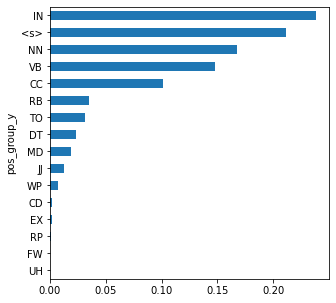

In [30]:
A.loc['NN'].cp.sort_values().plot.barh(figsize=(5,5)); # P(Ay|Ax)

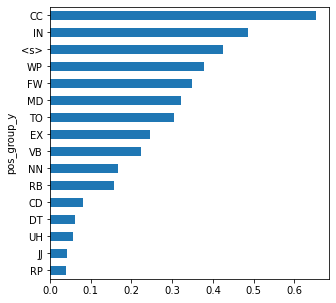

In [31]:
A.loc['NN'].rcp.sort_values().plot.barh(figsize=(5,5)); # p(Ax|Ay)

## Create Table of Initial State Probabilities ($\pi$ or `PI`)

In [32]:
PI = A.loc['<s>'] #.n.to_frame()
PI.index.name = 'pos_group'

In [33]:
# PI

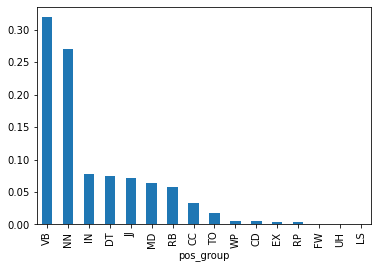

In [34]:
PI.sort_values('cp', ascending=False).cp.plot.bar();

## Create Table of $t_n \rightarrow o_n$ Emissions ($ B $)

In [35]:
B = TOKEN[['pos_group', 'term_str']].value_counts().to_frame('n')
B['cp'] = B.n / B.groupby('pos_group').n.sum()
B['rcp'] = B.n / B.groupby('term_str').n.sum()

In [36]:
BM = B.cp.unstack(fill_value=0)

In [37]:
B.loc['JJ'].sort_values('n', ascending=False).head(10)

,n,cp,rcp
term_str,,,
such,3029,0.019109,0.964957
little,2893,0.018251,0.914349
old,2640,0.016655,0.911602
good,2502,0.015784,0.877279
other,2382,0.015027,0.777923
own,2351,0.014832,0.847207
more,2199,0.013873,0.431430
much,2186,0.013791,0.637504
great,2154,0.013589,0.950154


In [38]:
B.loc['NN'].sort_values('n', ascending=False).head(10)

,n,cp,rcp
term_str,,,
it,4047,0.007792,0.781274
man,3630,0.006989,0.975020
mr,3330,0.006411,0.985207
time,3198,0.006157,0.967918
him,2793,0.005377,0.791218
mrs,2653,0.005108,0.998119
i,2302,0.004432,0.820970
me,2151,0.004141,0.683725
you,1940,0.003735,0.663475


In [39]:
B.loc['VB'].sort_values('n', ascending=False).head(10)

,n,cp,rcp
term_str,,,
was,23063,0.066908,0.985556
be,14890,0.043197,0.991675
had,13070,0.037917,0.985300
is,12663,0.036737,0.964947
have,10047,0.029147,0.994851
were,7801,0.022631,0.990226
been,5783,0.016777,0.983838
are,5365,0.015564,0.967015
said,4120,0.011953,0.918413


## Create a State Graph of $A$

We do this for the fun of it. It shows how complicated these state machines can get!

In [40]:
λ = .001
edges = A[A.cp > λ].apply(lambda x: f'"{x.name[0]}" -> "{x.name[1]}" [label="{round(x.cp,4)}"]', 1).to_list()

In [41]:
E = '\n'.join(edges)
G = "digraph G {\n"
G += "\trankdir=LR"
for edge in edges:
    G += f"\t{edge}\n"
G += "}\n"

In [42]:
with open(f'{data_home}/output/state-graph-{λ}.dot', 'w') as outfile:
    outfile.write(G)

In [43]:
!dot {data_home}/output/state-graph-{λ}.dot -Tpng -O

<img src="../data/output/state-graph-0.001.dot.png">

## Implement Viterbi


<img src="images/viterbi.png" width="750">

In [240]:
def viterbi(sent_str, print_results=True):
    """This is a work in progress :) """
    
    global POS_GROUP, AM, BM, PI
    
    # Grab the list of states, i.e. possible parts-of-speech
    states = POS_GROUP.index.to_list()
    
    # Get words from sentence (the observed sequence)
    W = [re.sub(r'[\W_]+', '', w) for w in sent_str.strip().lower().split()]
    
    # Define the number of observations
    T = len(W)
    
    # Create the lattice 
    lattice = pd.DataFrame(0., columns=states, index=[i for i in range(T)])
    
    # Fit the model to the sentence
    
    # The first time around we use the values in PI
    a = PI.cp # Probability of the tag at start of sentence
    b = BM.loc[:, W[0]] # List of probabable preceding tags for a word
    lattice.loc[0] = a * b
    lattice.loc[0] = lattice.loc[0].fillna(0.) 

    # After the first time, we compute the probability of each state
    # using A, B, and the previous term in the lattice
    for i in range(1, T):

        w = W[i]

        # States are just POS types
        for s in states:

            # Get transition probs for all states to this state
            try:
                a = AM.loc[:, s] # Vector of preceding states for a state
            except KeyError:
                lattice.loc[i, s] = 0
                continue
                            
            # Get emission prob for this state and this word
            try:
                b = BM.loc[s, w]
            except KeyError:
                lattice.loc[i, s] = 0
                continue
            
            # Get the previous results 
            x = lattice.loc[i-1] 

            # Get max value
            lattice.loc[i, s] = (x * a * b).max()

    lattice.index = W # Add names back to the columns
    path = lattice.idxmax(1).to_frame('pos_group')
    path['p'] = lattice.sum(1)
    path['i'] = np.log2(1/path.p)
    
    result = ' '.join(path.apply(lambda x: x.name + '/' + x.pos_group, 1).to_list())
    if print_results:
        print(f"{result}\n")
        
    path = path.reset_index().rename(columns={'index':'term_str'})
    path.index.name = 'token_num'
    
    return lattice, path, result 

# Try it out

In [241]:
test_sentences = """
The event had every promise of happiness for her friend 
Mr Weston was a man of unexceptionable character easy fortune suitable age and pleasant manners
and there was some satisfaction in considering with what self-denying generous friendship she had always wished and promoted the match
but it was a black morning's work for her 
The want of Miss Taylor would be felt every hour of every day 
She recalled her past kindness the kindness the affection of sixteen years 
how she had taught and how she had played with her from five years old 
how she had devoted all her powers to attach and amuse her in health 
and how nursed her through the various illnesses of childhood 
A large debt of gratitude was owing here 
but the intercourse of the last seven years 
the equal footing and perfect unreserve which had soon followed Isabella's marriage 
on their being left to each other was yet a dearer tenderer recollection 
She had been a friend and companion such as few possessed intelligent well-informed useful gentle 
knowing all the ways of the family 
interested in all its concerns 
and peculiarly interested in herself in every pleasure every scheme of hers 
one to whom she could speak every thought as it arose 
and who had such an affection for her as could never find fault 
How was she to bear the change 
It was true that her friend was going only half a mile from them 
but Emma was aware that great must be the difference between a Mrs Weston 
only half a mile from them 
and a Miss Taylor in the house 
and with all her advantages natural and domestic 
she was now in great danger of suffering from intellectual solitude 
She dearly loved her father 
but he was no companion for her 
He could not meet her in conversation rational or playful 
The evil of the actual disparity in their ages
and Mr Woodhouse had not married early
was much increased by his constitution and habits 
for having been a valetudinarian all his life 
without activity of mind or body 
he was a much older man in ways than in years 
and though everywhere beloved for the friendliness of his heart and his amiable temper 
his talents could not have recommended him at any time 
Her sister though comparatively but little removed by matrimony 
being settled in London only sixteen miles off was much beyond her daily reach 
and many a long October and November evening must be struggled through at Hartfield 
before Christmas brought the next visit from Isabella and her husband 
and their little children to fill the house and give her pleasant society again 
""".split('\n')[1:-1]

In [242]:
lattice, path, result = viterbi(test_sentences[0])

the/DT event/NN had/VB every/DT promise/NN of/IN happiness/NN for/IN her/NN friend/NN



In [243]:
lattice.T.style.background_gradient()

,the,event,had,every,promise,of,happiness,for,her,friend
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DT,0.039107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IN,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JJ,0.000097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NN,0.000371,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [244]:
path.style.background_gradient()

,term_str,pos_group,p,i
token_num,,,,
0,the,DT,0.039626,4.657405
1,event,NN,0.000010,16.555898
2,had,VB,0.000000,24.047898
3,every,DT,0.000000,33.005728
4,promise,NN,0.000000,45.843142
5,of,IN,0.000000,49.968598
6,happiness,NN,0.000000,62.226476
7,for,IN,0.000000,68.349652
8,her,NN,0.000000,78.376589


In [245]:
result

'the/DT event/NN had/VB every/DT promise/NN of/IN happiness/NN for/IN her/NN friend/NN'

In [246]:
for sent_str in test_sentences:
    viterbi(sent_str)

the/DT event/NN had/VB every/DT promise/NN of/IN happiness/NN for/IN her/NN friend/NN

mr/NN weston/NN was/VB a/DT man/NN of/IN unexceptionable/JJ character/NN easy/JJ fortune/NN suitable/JJ age/NN and/CC pleasant/JJ manners/NN

and/CC there/EX was/VB some/DT satisfaction/NN in/IN considering/VB with/IN what/WP selfdenying/CC generous/CC friendship/CC she/CC had/CC always/CC wished/CC and/CC promoted/CC the/CC match/CC

but/CC it/NN was/VB a/DT black/JJ mornings/NN work/NN for/IN her/NN

the/DT want/NN of/IN miss/NN taylor/NN would/MD be/VB felt/VB every/DT hour/NN of/IN every/DT day/NN

she/NN recalled/VB her/NN past/NN kindness/NN the/DT kindness/NN the/DT affection/NN of/IN sixteen/JJ years/NN

how/NN she/NN had/VB taught/VB and/CC how/NN she/NN had/VB played/VB with/IN her/NN from/IN five/CD years/NN old/JJ

how/NN she/NN had/VB devoted/VB all/DT her/NN powers/NN to/TO attach/VB and/CC amuse/VB her/NN in/IN health/NN

and/CC how/NN nursed/VB her/NN through/IN the/DT various/JJ illn